## *Maryam Mounad - Muhammad Humza Arain - Mahak Nadeem*

In [1]:
import torch
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 784
])

train_data = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_data = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

100%|██████████| 26.4M/26.4M [00:06<00:00, 4.23MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.06MB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.35MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 1.95MB/s]


In [2]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 2))
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 784),
            torch.nn.Sigmoid())

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc_mu = torch.nn.Linear(256, 2)
        self.fc_logvar = torch.nn.Linear(256, 2)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 784),
            torch.nn.Sigmoid())

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [3]:
def ae_loss(recon, x):
    return torch.nn.functional.binary_cross_entropy(recon, x, reduction='sum')

def vae_loss(recon, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize models and optimizers
ae = AE()
vae = VAE()
ae_optim = torch.optim.Adam(ae.parameters(), lr=0.01)
vae_optim = torch.optim.Adam(vae.parameters(), lr=0.01)

# Training loop for AE
for epoch in range(20):
    for x, _ in train_loader:
        recon = ae(x)
        loss = ae_loss(recon, x)
        ae_optim.zero_grad()
        loss.backward()
        ae_optim.step()

# Training loop for VAE
for epoch in range(20):
    for x, _ in train_loader:
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        vae_optim.zero_grad()
        loss.backward()
        vae_optim.step()

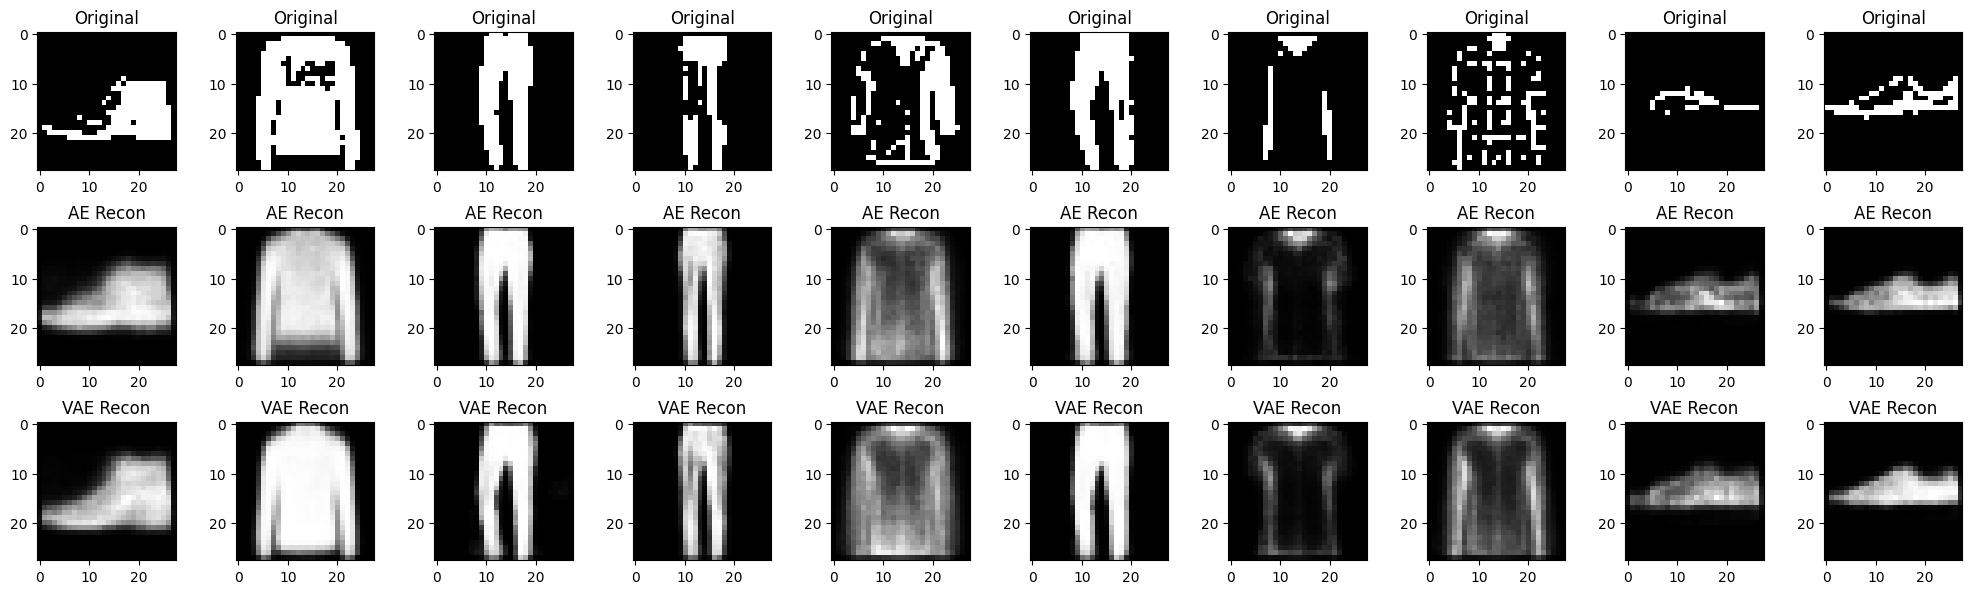

In [4]:
import matplotlib.pyplot as plt

# Get 10 test samples
test_samples = next(iter(test_loader))[0][:10]

# Reconstruct
ae_recon = ae(test_samples)
vae_recon, _, _ = vae(test_samples)

# Plot
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
for i in range(10):
    axes[0, i].imshow(test_samples[i].view(28, 28), cmap='gray')
    axes[1, i].imshow(ae_recon[i].detach().view(28, 28), cmap='gray')
    axes[2, i].imshow(vae_recon[i].detach().view(28, 28), cmap='gray')
    axes[0, i].set_title("Original")
    axes[1, i].set_title("AE Recon")
    axes[2, i].set_title("VAE Recon")
plt.tight_layout()
plt.show()

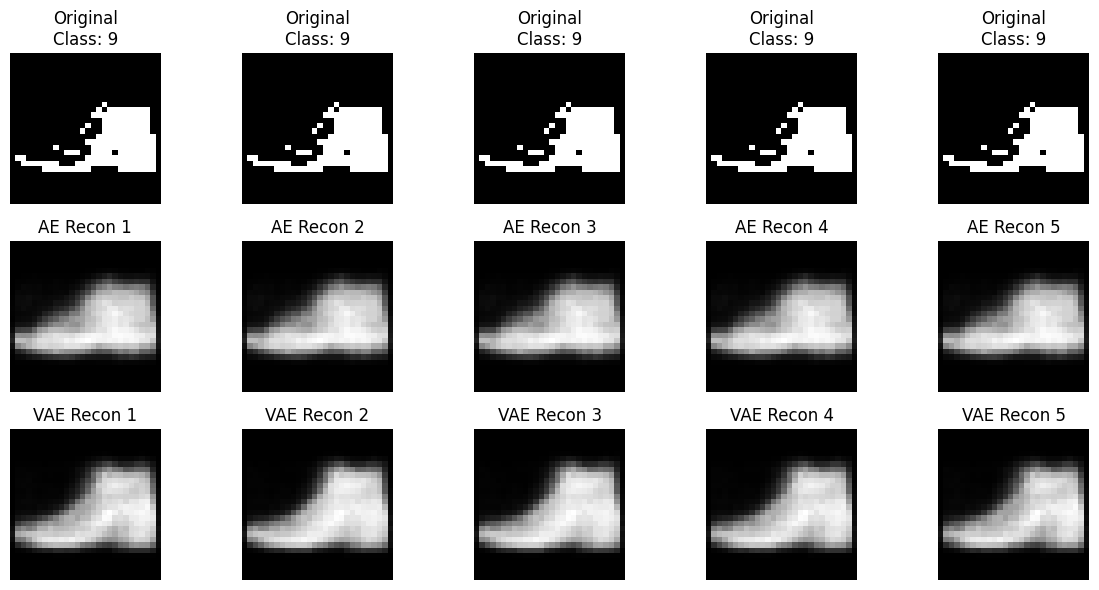

In [5]:
import numpy as np

# Select one test image
test_image, label = next(iter(test_loader))
sample_image = test_image[0].unsqueeze(0)

# Repeat the same image multiple times
n_repeats = 5
repeated_image = sample_image.repeat(n_repeats, 1)

with torch.no_grad():
    # AE reconstructions (deterministic)
    ae_recons = ae(repeated_image)

    # VAE reconstructions (stochastic)
    vae_recons = []
    for _ in range(n_repeats):
        recon, _, _ = vae(sample_image)  # Note: Using single image each time
        vae_recons.append(recon)
    vae_recons = torch.cat(vae_recons)

# Convert to numpy for plotting
original_img = sample_image.view(28, 28).numpy()
ae_recons = ae_recons.view(-1, 28, 28).numpy()
vae_recons = vae_recons.view(-1, 28, 28).numpy()

# Plot
fig, axes = plt.subplots(3, n_repeats, figsize=(12, 6))

# Original image
for i in range(n_repeats):
    axes[0, i].imshow(original_img, cmap='gray')
    axes[0, i].set_title(f"Original\nClass: {label[0].item()}")
    axes[0, i].axis('off')

# AE reconstructions
for i in range(n_repeats):
    axes[1, i].imshow(ae_recons[i], cmap='gray')
    axes[1, i].set_title(f"AE Recon {i+1}")
    axes[1, i].axis('off')

# VAE reconstructions
for i in range(n_repeats):
    axes[2, i].imshow(vae_recons[i], cmap='gray')
    axes[2, i].set_title(f"VAE Recon {i+1}")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

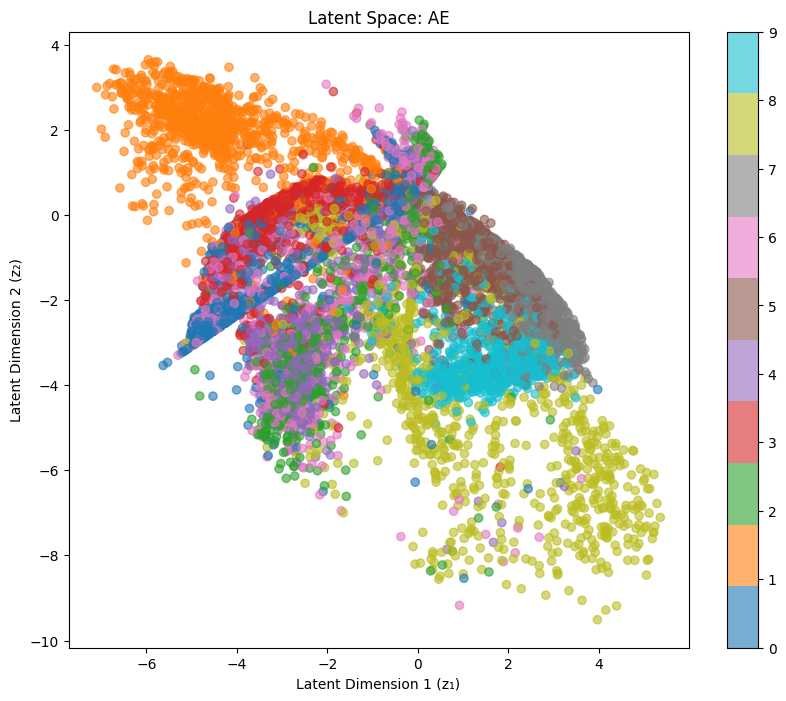

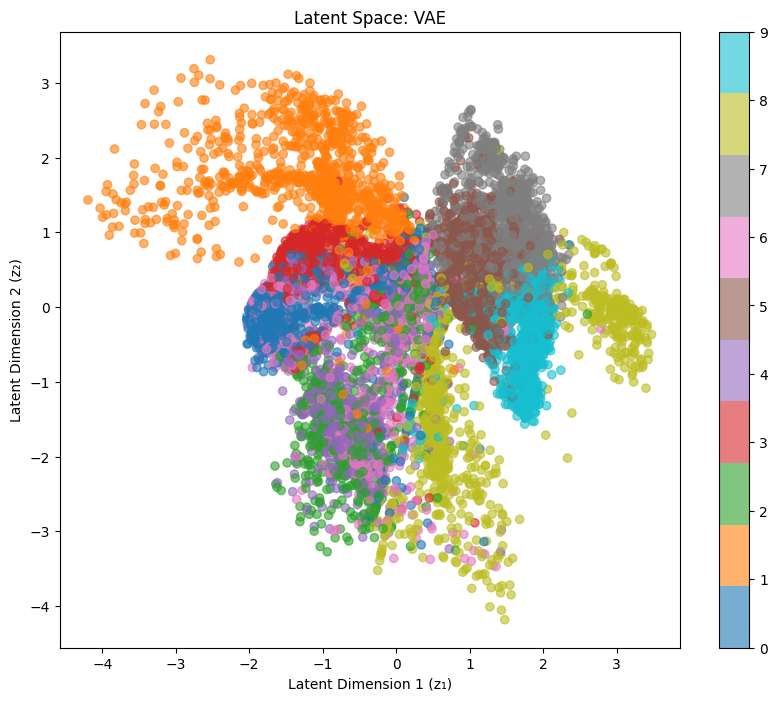

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_latent_space(model, test_loader, model_type='ae'):
    latents = []
    labels = []

    with torch.no_grad():
        for data, target in test_loader:
            if model_type == 'ae':
                z = model.encoder(data)
            else:  # VAE - use mean vector
                mu, _ = model.encode(data)
                z = mu
            latents.append(z)
            labels.append(target)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1],
                         c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(f'Latent Space: {model_type.upper()}')
    plt.xlabel('Latent Dimension 1 (z₁)')
    plt.ylabel('Latent Dimension 2 (z₂)')

# Generate plots
plot_latent_space(ae, test_loader, 'ae')
plot_latent_space(vae, test_loader, 'vae')
plt.show()

# Exercise 2 – Optuna hyperparameter optimization

In [7]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
import optuna

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

def objective(trial):
    # Hyperparameter search space
    epochs = trial.suggest_categorical('epochs', [10, 20, 30])
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    lr = trial.suggest_categorical('lr', [0.01, 0.1])

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_losses = []

    for train_idx, val_idx in kf.split(dataset):
        train_ds = Subset(dataset, train_idx)
        val_ds = Subset(dataset, val_idx)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = VAE()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Training
        model.train()
        for _ in range(epochs):
            for x, _ in train_loader:
                optimizer.zero_grad()
                recon, mu, logvar = model(x)
                # Binary cross-entropy loss
                loss = F.binary_cross_entropy(recon, x, reduction='sum')
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for x, _ in val_loader:
                recon, mu, logvar = model(x)
                val_loss = F.binary_cross_entropy(recon, x, reduction='sum')
                total_val_loss += val_loss.item()
        cv_losses.append(total_val_loss / len(val_ds))

    # Return average cross‑validated loss
    return sum(cv_losses) / len(cv_losses)

# 4. Run the study with TPE sampler
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=5)

# 5. Report results
print("Best hyperparameters:", study.best_params)
print("Best cross-validated loss:", study.best_value)

100%|██████████| 9.91M/9.91M [00:05<00:00, 1.66MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 260kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]
[I 2025-07-01 23:11:33,581] A new study created in memory with name: no-name-5cd9466e-a4d5-4c65-92cb-02b2f75a4e11
[I 2025-07-01 23:38:10,562] Trial 0 finished with value: 10420.308807291667 and parameters: {'epochs': 20, 'batch_size': 64, 'lr': 0.1}. Best is trial 0 with value: 10420.308807291667.
[W 2025-07-01 23:39:48,926] Trial 1 failed with parameters: {'epochs': 20, 'batch_size': 64, 'lr': 0.1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\user\AppData\Roaming\Python\Python312\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\user\AppData\Local\Temp\ipykernel_17564\3351828680.py", line 28, in objective
    for x, _ in train_

KeyboardInterrupt: 

# Interrupted the code because it was taking so much time 

# 2. What is the difference between TPE, random search and grid search? (1 point)


# Hyperparameter Search Strategies

##  Grid Search

- **What**: Try every possible combination on a predefined grid.
- **When**: Use for small, low-dimensional search spaces.
- **Pros**:
  - Exhaustive coverage of all combinations
  - Simple and reproducible
- **Cons**:
  - Does **not scale** well with dimensionality
  - Computationally expensive

---

##  Random Search

- **What**: Randomly sample combinations from the search space.
- **When**: Suitable for moderate to large spaces with a fixed trial budget.
- **Pros**:
  - Easy to implement
  - Can cover **more diverse regions** of high-dimensional spaces
- **Cons**:
  - Blind to previous outcomes
  - Might miss the best regions by chance

---

##  TPE (Tree-structured Parzen Estimator / Bayesian Search)

- **What**: Uses a probabilistic model to identify regions of the parameter space that are likely to produce good results.
- **When**: Use when you want to find strong-performing settings with **fewer trials**.
- **Pros**:
  - **Learns** from past evaluations
  - Efficient in identifying promising hyperparameters quickly
- **Cons**:
  - More computational overhead per trial
  - Requires probabilistic modeling infrastructure



